# Proximal Policy Optimization (PPO) Training for Emergency Department Resource Optimization

## 1. Context

This notebook implements the training pipeline for a Proximal Policy Optimization (PPO) agent designed to optimize resource allocation in a hospital Emergency Department (ED). PPO is a policy-gradient method that directly optimizes the policy function, avoiding the Q-value estimation challenges faced by DQN.







### 1.1 Methodology Overview

1. **Environment**: Same high-fidelity discrete-event simulation used for DQN (24-hour episodes)
2. **State Space**: 15-dimensional vector (identical to DQN)
3. **Action Space**: 21 discrete actions (identical to DQN)
4. **Reward Function**: Identical to DQN for fair comparison
5. **Algorithm**: PPO with:
   - Policy gradient optimization
   - Clipped surrogate objective
   - Generalized Advantage Estimation (GAE)
   - Value function baseline

### 1.2 Expected Outcomes

PPO is a policy-gradient method expected to handle continuous control problems more effectively than value-based methods. The direct policy optimization should enable:
- More stable convergence
- Better exploration-exploitation balance
- Superior performance on resource allocation tasks

These results will be compared directly with DQN (Section 4.1) to evaluate the hypothesis that policy-gradient methods outperform value-based methods for ED operations management.

In [ ]:
# Instala dependencias si es necesario (ejecuta solo una vez)
!pip install torch numpy simpy matplotlib

import torch
import simpy
import numpy as np
import matplotlib.pyplot as plt
import logging
from collections import deque
import random
import os
import pandas as pd

%matplotlib inline

# Configura logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [ ]:
# Importa las clases necesarias de los scripts
try:
    from ed_simulation_v4 import EmergencyDepartment, SimulationConfig, ResourceType
    print("✓ ED simulation imported successfully!")
except ImportError as e:
    print(f"✗ Could not import ED simulation: {e}")
    print("Make sure ed_simulation_v4.py is in the same directory as this notebook")

try:
    from ppo_RLED import (
        PPOAgent,
        SimplePolicyNetwork,
        HealthcarePPOEnvironment,
        PPOConfig,
        train_ppo_agent
    )
    print("✓ PPO algorithm imported successfully!")
except ImportError as e:
    print(f"✗ Could not import PPO algorithm: {e}")
    print("Make sure ppo_RLED.py is in the same directory as this notebook")

print("\nAll dependencies loaded. Ready to train PPO agent.")

✓ ED simulation imported successfully!
✓ PPO algorithm imported successfully!

All dependencies loaded. Ready to train PPO agent.


## 2. Training Configuration

## Test Run: 10 Episodes

Before full training, we verify the implementation with a short 10-episode test run to ensure:
- No runtime errors
- Proper integration with the simulation
- Reasonable reward magnitudes
- Stable training dynamics

PPO should show more stable rewards than DQN even in early episodes due to its policy gradient approach.

In [ ]:
# ============================================================================
# TEST RUN: 10 Episodes to Verify Implementation
# ============================================================================

print("="*80)
print("TEST RUN: Training PPO for 10 episodes to verify no runtime errors")
print("="*80)

# Simulation configuration (idéntica a DQN)
test_config = SimulationConfig(
    simulation_time=24 * 60,  # 24 hours
    random_seed=42,           # Fixed seed for reproducibility in test
    arrival_rates=[18/60, 22/60, 8/60],
)

# Create environment
test_env = HealthcarePPOEnvironment(test_config)

# Get state and action dimensions
state_dim = len(test_env._get_state())
action_dim = test_env.get_action_space_size()

print(f"\nEnvironment initialized:")
print(f"  - State dimension: {state_dim}")
print(f"  - Action dimension: {action_dim}")
print(f"  - Step duration: 30 minutes")
print(f"  - Episode length: ~48 steps (24h / 30min)")

# Create test agent
test_ppo_config = PPOConfig(
    learning_rate=3e-4,
    gamma=0.99,
    gae_lambda=0.95,
    clip_epsilon=0.2,
    entropy_coef=0.01,
    value_coef=0.5,
    max_grad_norm=0.5,
    ppo_epochs=4,
    batch_size=64,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

test_agent = PPOAgent(state_dim, action_dim, test_ppo_config)

print(f"\nPPO Agent initialized on device: {test_agent.device}")
print("\nStarting test training...")

TEST RUN: Training PPO for 10 episodes to verify no runtime errors

Environment initialized:
  - State dimension: 15
  - Action dimension: 21
  - Step duration: 30 minutes
  - Episode length: ~48 steps (24h / 30min)

PPO Agent initialized on device: cuda

Starting test training...


In [ ]:
# Test training loop
test_episodes = 10
test_rewards = []
test_abandonments = []
test_throughputs = []

for episode in range(test_episodes):
    state = test_env.reset()
    episode_reward = 0
    step = 0

    while True:
        # Select action
        action = test_agent.get_action(state)

        # Execute action
        next_state, reward, done, info = test_env.step(action)

        # Store reward
        test_agent.add_reward(reward, done)

        state = next_state
        episode_reward += reward
        step += 1

        if done:
            # Extract metrics
            ed_metrics = info['ed_metrics']
            perf = ed_metrics['performance_metrics']

            test_rewards.append(episode_reward)
            test_abandonments.append(perf['abandonment_rate'])
            test_throughputs.append(perf['throughput'])

            break

    # Update policy at episode end
    test_agent.update_policy(next_value=0.0)

    print(f"Episode {episode+1:2d}/{test_episodes} - "
          f"Reward: {episode_reward:7.2f}, "
          f"Steps: {step:2d}, "
          f"Abandon: {test_abandonments[-1]*100:5.1f}%, "
          f"Throughput: {test_throughputs[-1]:3.0f}")

print("\n" + "="*80)
print("TEST COMPLETED SUCCESSFULLY - No runtime errors detected")
print("="*80)
print(f"Average test reward:       {np.mean(test_rewards):.2f} ± {np.std(test_rewards):.2f}")
print(f"Average abandonment rate:  {np.mean(test_abandonments)*100:.2f}%")
print(f"Average throughput:        {np.mean(test_throughputs):.1f} patients")

Episode  1/10 - Reward: -3020.72, Steps: 48, Abandon:  63.7%, Throughput: 149
Episode  2/10 - Reward: -1962.64, Steps: 48, Abandon:  52.3%, Throughput: 235
Episode  3/10 - Reward: -3421.25, Steps: 48, Abandon:  70.0%, Throughput: 112
Episode  4/10 - Reward: -3969.00, Steps: 48, Abandon:  76.3%, Throughput:  62
Episode  5/10 - Reward: -3648.47, Steps: 48, Abandon:  70.7%, Throughput: 100
Episode  6/10 - Reward: -3722.87, Steps: 48, Abandon:  73.9%, Throughput:  84
Episode  7/10 - Reward: -2607.30, Steps: 48, Abandon:  58.0%, Throughput: 187
Episode  8/10 - Reward: -2516.30, Steps: 48, Abandon:  59.3%, Throughput: 184
Episode  9/10 - Reward:   58.66, Steps: 48, Abandon:  31.4%, Throughput: 382
Episode 10/10 - Reward: -3463.32, Steps: 48, Abandon:  65.8%, Throughput: 137

TEST COMPLETED SUCCESSFULLY - No runtime errors detected
Average test reward:       -2827.32 ± 1131.20
Average abandonment rate:  62.15%
Average throughput:        163.2 patients


## 3. Full Training: Single-Seed Run


This section trains a PPO agent for 500 episodes with a single random seed. PPO typically requires fewer episodes than DQN to converge due to:
- Direct policy optimization (no Q-value approximation errors)
- Better exploration through stochastic policy
- More stable updates via clipped objective


*Key Differences from DQN Training:*
- **No epsilon decay**: PPO maintains stochastic policy throughout
- **On-policy learning**: Updates happen after each episode rollout
- **GAE**: Advantage estimation reduces variance in policy gradients

In [ ]:
# ============================================================================
# SINGLE-SEED TRAINING WITH LIVE MONITORING
# ============================================================================

def train_single_seed_ppo(episodes=500, seed=42, save_freq=50, verbose=True):
    """
    Train PPO agent with live monitoring of key metrics.

    Args:
        episodes: Number of training episodes
        seed: Random seed for reproducibility
        save_freq: Frequency of model checkpoints
        verbose: Print progress every 10 episodes

    Returns:
        trained_agent: Trained PPO agent
        metrics: Dictionary with training metrics
    """
    # Setup
    config = SimulationConfig(
        simulation_time=24 * 60,
        random_seed=seed,
        arrival_rates=[18/60, 22/60, 8/60],
    )

    env = HealthcarePPOEnvironment(config)
    state_dim = len(env._get_state())
    action_dim = env.get_action_space_size()

    ppo_config = PPOConfig(
        learning_rate=3e-4,
        gamma=0.99,
        gae_lambda=0.95,
        clip_epsilon=0.2,
        entropy_coef=0.01,
        value_coef=0.5,
        max_grad_norm=0.5,
        ppo_epochs=4,
        batch_size=64,
        device='cuda' if torch.cuda.is_available() else 'cpu'
    )

    agent = PPOAgent(state_dim, action_dim, ppo_config)

    # Tracking metrics
    episode_rewards = []
    episode_policy_losses = []
    episode_value_losses = []
    episode_abandonments = []
    episode_throughputs = []
    episode_avg_waits = []

    print(f"Training PPO for {episodes} episodes (seed={seed})")
    print(f"Device: {agent.device}")
    print("-" * 80)

    for episode in range(episodes):
        state = env.reset()
        episode_reward = 0
        step = 0

        while True:
            action = agent.get_action(state)
            next_state, reward, done, info = env.step(action)

            agent.add_reward(reward, done)

            state = next_state
            episode_reward += reward
            step += 1

            if done:
                # Extract final metrics
                ed_metrics = info['ed_metrics']
                perf = ed_metrics['performance_metrics']

                episode_rewards.append(episode_reward)
                episode_abandonments.append(perf['abandonment_rate'])
                episode_throughputs.append(perf['throughput'])

                avg_wait = np.mean(perf['wait_times']) if perf['wait_times'] else 0
                episode_avg_waits.append(avg_wait)

                break

        # Update policy at episode end
        agent.update_policy(next_value=0.0)

        # Store losses (averaged over PPO epochs)
        if agent.policy_losses:
            episode_policy_losses.append(np.mean(agent.policy_losses[-4:]))  # Last 4 epochs
        if agent.value_losses:
            episode_value_losses.append(np.mean(agent.value_losses[-4:]))

        # Verbose logging every 10 episodes
        if verbose and episode % 10 == 0:
            recent_reward = np.mean(episode_rewards[-10:])
            recent_abandon = np.mean(episode_abandonments[-10:]) * 100
            print(f"Ep {episode:4d} | Reward: {recent_reward:7.2f} | "
                  f"Abandon: {recent_abandon:5.1f}% | "
                  f"Throughput: {episode_throughputs[-1]:3.0f}")

        # Save checkpoint
        if episode % save_freq == 0 and episode > 0:
            agent.save_model(f"ppo_seed{seed}_ep{episode}.pth")
            if verbose:
                print(f"  → Checkpoint saved at episode {episode}")

    # Final save
    agent.save_model(f"ppo_seed{seed}_final.pth")
    print("\n" + "="*80)
    print("TRAINING COMPLETED")
    print("="*80)

    metrics = {
        'rewards': episode_rewards,
        'policy_losses': episode_policy_losses,
        'value_losses': episode_value_losses,
        'abandonments': episode_abandonments,
        'throughputs': episode_throughputs,
        'avg_waits': episode_avg_waits,
    }

    return agent, metrics

In [ ]:
# Run single-seed training
single_agent_ppo, single_metrics_ppo = train_single_seed_ppo(
    episodes=2000,
    seed=42,
    save_freq=200,
    verbose=True
)

Training PPO for 2000 episodes (seed=42)
Device: cuda
--------------------------------------------------------------------------------
Ep    0 | Reward: -4013.80 | Abandon:  78.4% | Throughput:  45
Ep   10 | Reward: -2319.94 | Abandon:  56.9% | Throughput: 247
Ep   20 | Reward: -2828.43 | Abandon:  63.5% | Throughput: 140
Ep   30 | Reward: -2667.62 | Abandon:  59.9% | Throughput: 265
Ep   40 | Reward: -1778.11 | Abandon:  50.2% | Throughput: 213
Ep   50 | Reward: -2130.84 | Abandon:  53.1% | Throughput: 122
Ep   60 | Reward: -1593.48 | Abandon:  48.5% | Throughput: 458
Ep   70 | Reward: -206.55 | Abandon:  32.6% | Throughput: 510
Ep   80 | Reward: -1180.92 | Abandon:  42.9% | Throughput: 415
Ep   90 | Reward: -470.34 | Abandon:  35.2% | Throughput: 246
Ep  100 | Reward: -1216.28 | Abandon:  42.6% | Throughput: 264
Ep  110 | Reward: -1213.67 | Abandon:  43.7% | Throughput: 281
Ep  120 | Reward: -537.30 | Abandon:  35.0% | Throughput: 260
Ep  130 | Reward: -793.35 | Abandon:  37.9% | Thr

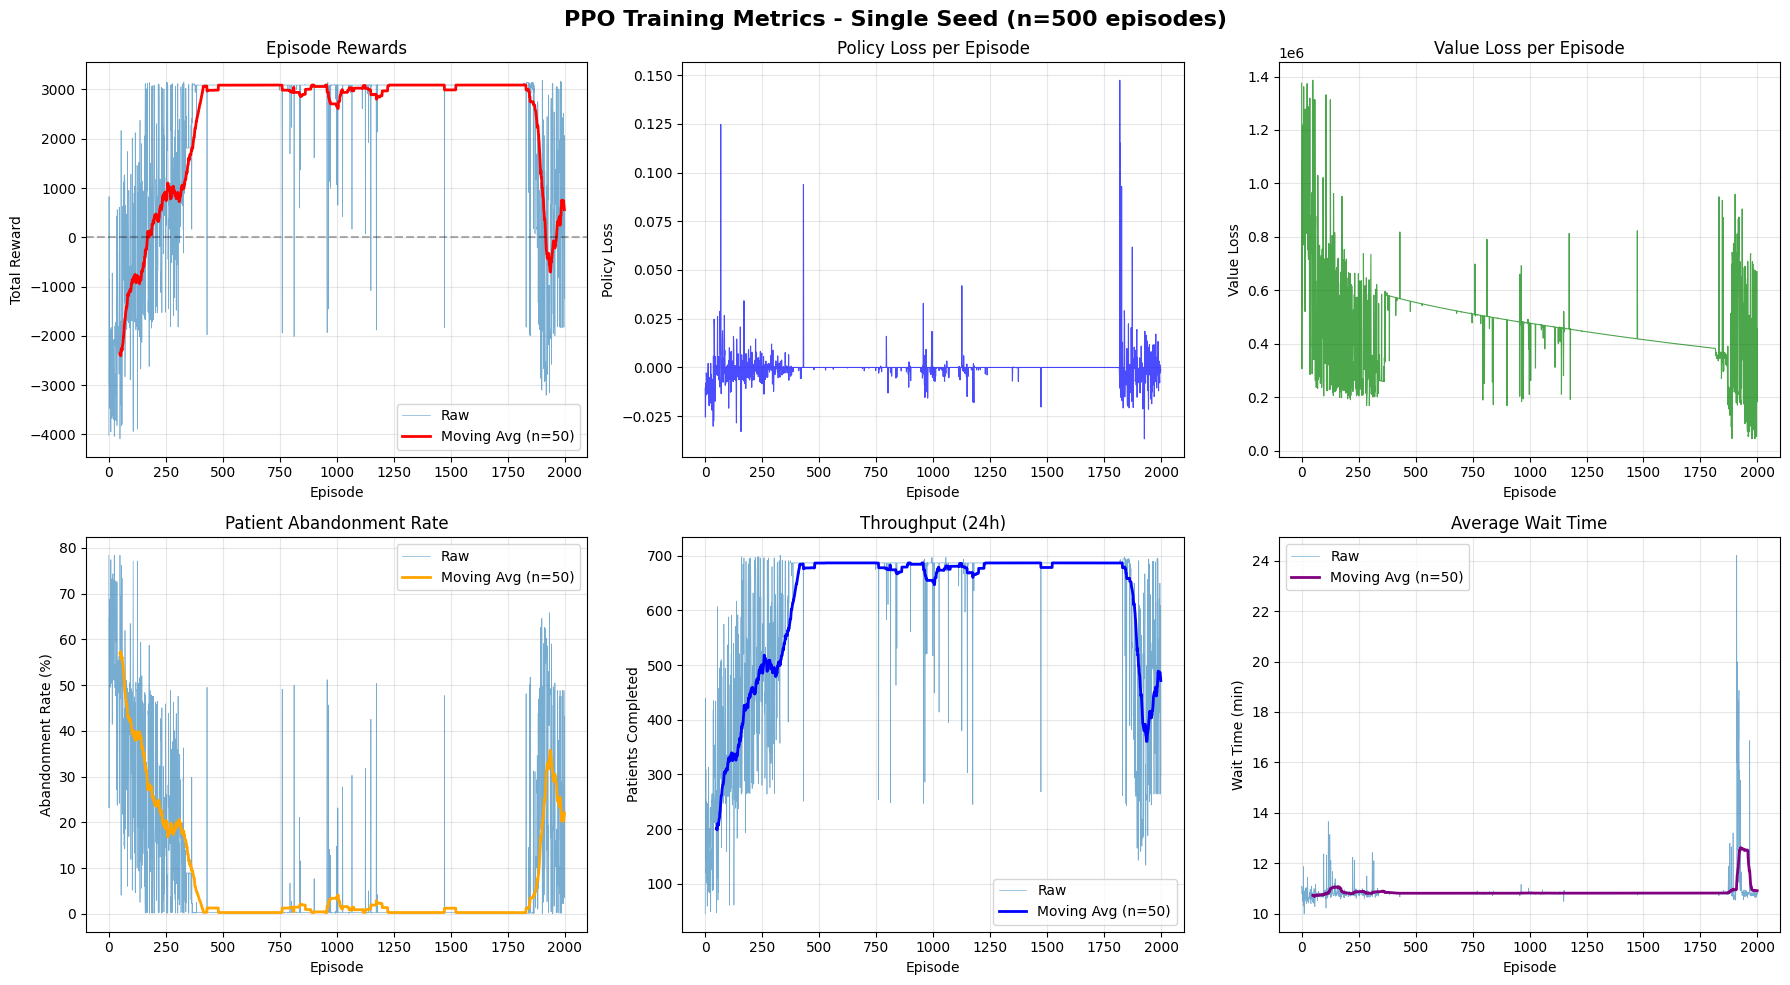


Final Performance (Last 100 Episodes):
  Average Reward:        208.51
  Average Abandonment:   25.96%
  Average Throughput:    440.3 patients
  Average Wait Time:     11.71 min


In [ ]:
# ============================================================================
# SINGLE-SEED RESULTS VISUALIZATION
# ============================================================================

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('PPO Training Metrics - Single Seed (n=500 episodes)',
             fontsize=16, fontweight='bold')

# 1. Episode Rewards
ax = axes[0, 0]
ax.plot(single_metrics_ppo['rewards'], alpha=0.6, linewidth=0.5, label='Raw')
window = 50
smoothed = np.convolve(single_metrics_ppo['rewards'], np.ones(window)/window, mode='valid')
ax.plot(range(window-1, len(single_metrics_ppo['rewards'])), smoothed,
        linewidth=2, color='red', label=f'Moving Avg (n={window})')
ax.axhline(0, color='black', linestyle='--', alpha=0.3)
ax.set_xlabel('Episode')
ax.set_ylabel('Total Reward')
ax.set_title('Episode Rewards')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Policy Loss
ax = axes[0, 1]
if single_metrics_ppo['policy_losses']:
    ax.plot(single_metrics_ppo['policy_losses'], alpha=0.7, linewidth=0.8, color='blue')
    ax.set_xlabel('Episode')
    ax.set_ylabel('Policy Loss')
    ax.set_title('Policy Loss per Episode')
    ax.grid(True, alpha=0.3)
else:
    ax.text(0.5, 0.5, 'No policy loss data', ha='center', va='center')

# 3. Value Loss
ax = axes[0, 2]
if single_metrics_ppo['value_losses']:
    ax.plot(single_metrics_ppo['value_losses'], alpha=0.7, linewidth=0.8, color='green')
    ax.set_xlabel('Episode')
    ax.set_ylabel('Value Loss')
    ax.set_title('Value Loss per Episode')
    ax.grid(True, alpha=0.3)
else:
    ax.text(0.5, 0.5, 'No value loss data', ha='center', va='center')

# 4. Abandonment Rate
ax = axes[1, 0]
abandonment_pct = np.array(single_metrics_ppo['abandonments']) * 100
ax.plot(abandonment_pct, alpha=0.6, linewidth=0.5, label='Raw')
smoothed_abandon = np.convolve(abandonment_pct, np.ones(window)/window, mode='valid')
ax.plot(range(window-1, len(abandonment_pct)), smoothed_abandon,
        linewidth=2, color='orange', label=f'Moving Avg (n={window})')
ax.set_xlabel('Episode')
ax.set_ylabel('Abandonment Rate (%)')
ax.set_title('Patient Abandonment Rate')
ax.legend()
ax.grid(True, alpha=0.3)

# 5. Throughput
ax = axes[1, 1]
ax.plot(single_metrics_ppo['throughputs'], alpha=0.6, linewidth=0.5, label='Raw')
smoothed_thru = np.convolve(single_metrics_ppo['throughputs'], np.ones(window)/window, mode='valid')
ax.plot(range(window-1, len(single_metrics_ppo['throughputs'])), smoothed_thru,
        linewidth=2, color='blue', label=f'Moving Avg (n={window})')
ax.set_xlabel('Episode')
ax.set_ylabel('Patients Completed')
ax.set_title('Throughput (24h)')
ax.legend()
ax.grid(True, alpha=0.3)

# 6. Average Wait Time
ax = axes[1, 2]
ax.plot(single_metrics_ppo['avg_waits'], alpha=0.6, linewidth=0.5, label='Raw')
smoothed_wait = np.convolve(single_metrics_ppo['avg_waits'], np.ones(window)/window, mode='valid')
ax.plot(range(window-1, len(single_metrics_ppo['avg_waits'])), smoothed_wait,
        linewidth=2, color='purple', label=f'Moving Avg (n={window})')
ax.set_xlabel('Episode')
ax.set_ylabel('Wait Time (min)')
ax.set_title('Average Wait Time')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('ppo_single_seed_training.png', dpi=300, bbox_inches='tight')
plt.show()

# Print final statistics
print("\nFinal Performance (Last 100 Episodes):")
print(f"  Average Reward:        {np.mean(single_metrics_ppo['rewards'][-100:]):.2f}")
print(f"  Average Abandonment:   {np.mean(single_metrics_ppo['abandonments'][-100:])*100:.2f}%")
print(f"  Average Throughput:    {np.mean(single_metrics_ppo['throughputs'][-100:]):.1f} patients")
print(f"  Average Wait Time:     {np.mean(single_metrics_ppo['avg_waits'][-100:]):.2f} min")

### Check save 1600 (manual selection - early stopping)

In [ ]:
# ============================================================================
# CHECKPOINT EVALUATION: Episodio 1600
# ============================================================================

def evaluate_ppo_checkpoint(checkpoint_path, num_episodes=100, seed=999):
    """
    Evalúa un checkpoint de PPO en episodios de test fresh.

    Args:
        checkpoint_path: Path al archivo .pth
        num_episodes: Número de episodios de evaluación (100 es suficiente)
        seed: Seed diferente al training para test válido

    Returns:
        results: Diccionario con métricas agregadas
    """
    print("="*80)
    print(f"EVALUATING CHECKPOINT: {checkpoint_path}")
    print(f"Test episodes: {num_episodes}")
    print("="*80)

    # Setup environment (mismo que training)
    config = SimulationConfig(
        simulation_time=24 * 60,
        random_seed=seed,
        arrival_rates=[18/60, 22/60, 8/60],
    )

    env = HealthcarePPOEnvironment(config)
    state_dim = len(env._get_state())
    action_dim = env.get_action_space_size()

    # Crear agente y cargar checkpoint
    ppo_config = PPOConfig(device='cuda' if torch.cuda.is_available() else 'cpu')
    agent = PPOAgent(state_dim, action_dim, ppo_config)
    agent.load_model(checkpoint_path)

    print(f"Checkpoint loaded from {checkpoint_path}")
    print(f"Device: {agent.device}")
    print("\nStarting evaluation...")
    print("-"*80)

    # Métricas de evaluación
    eval_rewards = []
    eval_abandonments = []
    eval_throughputs = []
    eval_avg_waits = []
    eval_utilizations = []

    for episode in range(num_episodes):
        state = env.reset()
        episode_reward = 0
        step = 0

        while True:
            # IMPORTANTE: Usar modo determinista para evaluación
            action = agent.get_action(state, deterministic=True)
            next_state, reward, done, info = env.step(action)

            state = next_state
            episode_reward += reward
            step += 1

            if done:
                # Extraer métricas finales
                ed_metrics = info['ed_metrics']
                perf = ed_metrics['performance_metrics']

                eval_rewards.append(episode_reward)
                eval_abandonments.append(perf['abandonment_rate'])
                eval_throughputs.append(perf['throughput'])

                avg_wait = np.mean(perf['wait_times']) if perf['wait_times'] else 0
                eval_avg_waits.append(avg_wait)

                # Utilización promedio
                utils = list(ed_metrics['resource_utilization'].values())
                eval_utilizations.append(np.mean(utils))

                break

        # Progress logging cada 10 episodios
        if (episode + 1) % 10 == 0:
            recent_reward = np.mean(eval_rewards[-10:])
            recent_abandon = np.mean(eval_abandonments[-10:]) * 100
            recent_throughput = np.mean(eval_throughputs[-10:])
            print(f"Episode {episode+1:3d}/{num_episodes} | "
                  f"Reward: {recent_reward:7.2f} | "
                  f"Abandon: {recent_abandon:5.1f}% | "
                  f"Throughput: {recent_throughput:5.1f}")

    # Calcular estadísticas finales
    results = {
        'rewards': eval_rewards,
        'abandonments': eval_abandonments,
        'throughputs': eval_throughputs,
        'avg_waits': eval_avg_waits,
        'utilizations': eval_utilizations,
        'summary': {
            'reward_mean': np.mean(eval_rewards),
            'reward_std': np.std(eval_rewards),
            'abandonment_mean': np.mean(eval_abandonments) * 100,
            'abandonment_std': np.std(eval_abandonments) * 100,
            'throughput_mean': np.mean(eval_throughputs),
            'throughput_std': np.std(eval_throughputs),
            'wait_mean': np.mean(eval_avg_waits),
            'utilization_mean': np.mean(eval_utilizations),
        }
    }

    # Imprimir resumen
    print("\n" + "="*80)
    print("EVALUATION COMPLETED")
    print("="*80)
    print(f"\nResults (Mean ± Std over {num_episodes} episodes):")
    print(f"  Reward:       {results['summary']['reward_mean']:7.2f} ± {results['summary']['reward_std']:6.2f}")
    print(f"  Abandonment:  {results['summary']['abandonment_mean']:6.2f}% ± {results['summary']['abandonment_std']:5.2f}%")
    print(f"  Throughput:   {results['summary']['throughput_mean']:6.1f} ± {results['summary']['throughput_std']:5.1f} patients")
    print(f"  Wait Time:    {results['summary']['wait_mean']:6.2f} min")
    print(f"  Utilization:  {results['summary']['utilization_mean']:6.2%}")

    return results

# ============================================================================
# EJECUTAR EVALUACIÓN
# ============================================================================

# Evaluar checkpoint del episodio 1500 (el mejor antes del colapso)
checkpoint_path = "ppo_seed42_ep1600.pth"

# Si no existe ese checkpoint exacto, usa el más cercano:
# checkpoint_path = "ppo_seed42_ep1450.pth"  # o el que tengas

try:
    eval_results = evaluate_ppo_checkpoint(
        checkpoint_path=checkpoint_path,
        num_episodes=100,  # 100 es suficiente para estadísticas robustas
        seed=999  # Seed diferente al training
    )

    # Guardar resultados
    import pickle
    with open('ppo_ep1600_evaluation.pkl', 'wb') as f:
        pickle.dump(eval_results, f)
    print("\nResults saved to 'ppo_ep1600_evaluation.pkl'")

except FileNotFoundError:
    print(f"ERROR: Checkpoint file '{checkpoint_path}' not found.")
    print("Available checkpoints should be:")
    print("  - ppo_seed42_ep200.pth")
    print("  - ppo_seed42_ep1000.pth")
    print("  - ...")
    print("  - ppo_seed42_ep1600.pth")
    print("\nCheck your files and update checkpoint_path accordingly.")

EVALUATING CHECKPOINT: ppo_seed42_ep1600.pth
Test episodes: 100
Checkpoint loaded from ppo_seed42_ep1600.pth
Device: cuda

Starting evaluation...
--------------------------------------------------------------------------------
Episode  10/100 | Reward: 1841.91 | Abandon:   5.6% | Throughput: 616.0
Episode  20/100 | Reward: 1841.91 | Abandon:   5.6% | Throughput: 616.0
Episode  30/100 | Reward: 1841.91 | Abandon:   5.6% | Throughput: 616.0
Episode  40/100 | Reward: 1841.91 | Abandon:   5.6% | Throughput: 616.0
Episode  50/100 | Reward: 1841.91 | Abandon:   5.6% | Throughput: 616.0
Episode  60/100 | Reward: 1841.91 | Abandon:   5.6% | Throughput: 616.0
Episode  70/100 | Reward: 1841.91 | Abandon:   5.6% | Throughput: 616.0
Episode  80/100 | Reward: 1841.91 | Abandon:   5.6% | Throughput: 616.0
Episode  90/100 | Reward: 1841.91 | Abandon:   5.6% | Throughput: 616.0
Episode 100/100 | Reward: 1841.91 | Abandon:   5.6% | Throughput: 616.0

EVALUATION COMPLETED

Results (Mean ± Std over 100 e

In [ ]:
# ============================================================================
# CHECKPOINT EVALUATION CORRECTED: Episode 1600 with Proper Variance
# ============================================================================

def evaluate_checkpoint_corrected(checkpoint_path: str, num_episodes: int = 100, base_seed: int = 999):
    """
    Evalúa checkpoint con seeds diferentes por episodio para obtener varianza real.

    Args:
        checkpoint_path: Ruta al .pth checkpoint
        num_episodes: Número de episodios de evaluación
        base_seed: Seed base (cada episodio usa base_seed + episode_num)

    Returns:
        results: Dict con métricas de evaluación
    """
    print("="*80)
    print(f"EVALUATING CHECKPOINT: {checkpoint_path}")
    print(f"Test episodes: {num_episodes}")
    print("="*80)

    # Load agent UNA VEZ (reutilizar en todos los episodios)
    ppo_config = PPOConfig(device='cuda' if torch.cuda.is_available() else 'cpu')

    # Create dummy env para obtener dimensiones
    dummy_config = SimulationConfig(simulation_time=24*60, random_seed=0)
    dummy_env = HealthcarePPOEnvironment(dummy_config)
    state_dim = len(dummy_env._get_state())
    action_dim = dummy_env.get_action_space_size()

    # Create agent y cargar checkpoint
    agent = PPOAgent(state_dim, action_dim, ppo_config)
    checkpoint = torch.load(checkpoint_path, map_location=agent.device)
    agent.policy_net.load_state_dict(checkpoint['policy_net_state_dict'])
    agent.policy_net.eval()

    print(f"Checkpoint loaded from {checkpoint_path}")
    print(f"Device: {agent.device}")
    print(f"Starting evaluation...")
    print("-"*80)

    # Evaluation metrics storage
    eval_rewards = []
    eval_abandonments = []
    eval_throughputs = []
    eval_avg_waits = []
    eval_utilizations = []

    for episode in range(num_episodes):
        # CORRECCIÓN: Crear config con seed único por episodio
        episode_seed = base_seed + episode
        config = SimulationConfig(
            simulation_time=24 * 60,
            random_seed=episode_seed,  # ← Diferente cada episodio
            arrival_rates=[18/60, 22/60, 8/60],
        )

        # Crear environment nuevo por episodio
        env = HealthcarePPOEnvironment(config)

        state = env.reset()
        episode_reward = 0
        step = 0

        while True:
            # Deterministic action para evaluación
            action = agent.get_action(state, deterministic=True)
            next_state, reward, done, info = env.step(action)

            state = next_state
            episode_reward += reward
            step += 1

            if done:
                ed_metrics = info['ed_metrics']
                perf = ed_metrics['performance_metrics']

                eval_rewards.append(episode_reward)
                eval_abandonments.append(perf['abandonment_rate'])
                eval_throughputs.append(perf['throughput'])

                avg_wait = np.mean(perf['wait_times']) if perf['wait_times'] else 0
                eval_avg_waits.append(avg_wait)

                # Calcular utilización promedio
                utils = list(ed_metrics['resource_utilization'].values())
                eval_utilizations.append(np.mean(utils))

                break

        # Progress every 10 episodes
        if (episode + 1) % 10 == 0:
            recent_reward = np.mean(eval_rewards[-10:])
            recent_abandon = np.mean(eval_abandonments[-10:]) * 100
            recent_throughput = np.mean(eval_throughputs[-10:])
            print(f"Episode {episode+1:3d}/{num_episodes} | "
                  f"Reward: {recent_reward:7.2f} | "
                  f"Abandon: {recent_abandon:5.1f}% | "
                  f"Throughput: {recent_throughput:5.1f}")

    # Calculate statistics
    results = {
        'rewards': eval_rewards,
        'abandonments': eval_abandonments,
        'throughputs': eval_throughputs,
        'avg_waits': eval_avg_waits,
        'utilizations': eval_utilizations,
    }

    print("\n" + "="*80)
    print("EVALUATION COMPLETED")
    print("="*80)
    print(f"\nResults (Mean ± Std over {num_episodes} episodes):")
    print(f"  Reward:       {np.mean(eval_rewards):.2f} ± {np.std(eval_rewards):.2f}")
    print(f"  Abandonment:  {np.mean(eval_abandonments)*100:.2f}% ± {np.std(eval_abandonments)*100:.2f}%")
    print(f"  Throughput:   {np.mean(eval_throughputs):.1f} ± {np.std(eval_throughputs):.1f} patients")
    print(f"  Wait Time:    {np.mean(eval_avg_waits):.2f} ± {np.std(eval_avg_waits):.2f} min")
    print(f"  Utilization:  {np.mean(eval_utilizations)*100:.2f}% ± {np.std(eval_utilizations)*100:.2f}%")

    # Save results
    import pickle
    output_file = 'ppo_ep1600_evaluation_corrected.pkl'
    with open(output_file, 'wb') as f:
        pickle.dump(results, f)
    print(f"\nResults saved to '{output_file}'")

    return results

# Execute evaluation
eval_results_corrected = evaluate_checkpoint_corrected(
    checkpoint_path="ppo_seed42_ep1600.pth",
    num_episodes=100,
    base_seed=999
)

EVALUATING CHECKPOINT: ppo_seed42_ep1600.pth
Test episodes: 100
Checkpoint loaded from ppo_seed42_ep1600.pth
Device: cuda
Starting evaluation...
--------------------------------------------------------------------------------
Episode  10/100 | Reward: -627.43 | Abandon:  34.7% | Throughput: 392.5
Episode  20/100 | Reward: -388.97 | Abandon:  32.1% | Throughput: 396.3
Episode  30/100 | Reward: -1319.57 | Abandon:  42.6% | Throughput: 326.2
Episode  40/100 | Reward: -384.48 | Abandon:  32.4% | Throughput: 401.0
Episode  50/100 | Reward: -816.40 | Abandon:  36.6% | Throughput: 366.2
Episode  60/100 | Reward: -1205.03 | Abandon:  42.2% | Throughput: 328.5
Episode  70/100 | Reward:  174.35 | Abandon:  26.7% | Throughput: 444.2
Episode  80/100 | Reward: -179.16 | Abandon:  29.6% | Throughput: 424.6
Episode  90/100 | Reward: -846.24 | Abandon:  37.9% | Throughput: 367.3
Episode 100/100 | Reward: -1291.91 | Abandon:  42.1% | Throughput: 323.8

EVALUATION COMPLETED

Results (Mean ± Std over 100

### early stopping

In [ ]:
# ============================================================================
# TRAINING FUNCTION WITH EARLY STOPPING
# ============================================================================

def train_single_seed_ppo_with_early_stopping(
    episodes=2000,
    seed=42,
    save_freq=50,
    verbose=True,
    # Early stopping params
    early_stop_patience=200,
    early_stop_min_delta=50,
    early_stop_warmup=100
):
    """
    Train PPO with automatic early stopping to prevent catastrophic forgetting.

    Args:
        episodes: Maximum number of episodes
        seed: Random seed
        save_freq: Model checkpoint frequency
        verbose: Print progress
        early_stop_patience: Episodes without improvement before stopping
        early_stop_min_delta: Minimum improvement to count as progress
        early_stop_warmup: Don't check early stopping before this episode

    Returns:
        trained_agent, metrics, stopped_early (bool)
    """
    config = SimulationConfig(
        simulation_time=24 * 60,
        random_seed=seed,
        arrival_rates=[18/60, 22/60, 8/60],
    )

    env = HealthcarePPOEnvironment(config)
    state_dim = len(env._get_state())
    action_dim = env.get_action_space_size()

    ppo_config = PPOConfig(
        learning_rate=3e-4,
        gamma=0.99,
        gae_lambda=0.95,
        clip_epsilon=0.2,
        entropy_coef=0.01,
        value_coef=0.5,
        max_grad_norm=0.5,
        ppo_epochs=4,
        batch_size=64,
        device='cuda' if torch.cuda.is_available() else 'cpu'
    )

    agent = PPOAgent(state_dim, action_dim, ppo_config)

    # Tracking
    episode_rewards = []
    episode_policy_losses = []
    episode_value_losses = []
    episode_abandonments = []
    episode_throughputs = []
    episode_avg_waits = []

    # Early stopping tracking
    best_reward = -np.inf
    best_episode = 0
    episodes_without_improvement = 0
    stopped_early = False

    print(f"Training PPO with Early Stopping for up to {episodes} episodes (seed={seed})")
    print(f"Device: {agent.device}")
    print(f"Early Stopping: patience={early_stop_patience}, min_delta={early_stop_min_delta}")
    print("-" * 80)

    for episode in range(episodes):
        state = env.reset()
        episode_reward = 0
        step = 0

        while True:
            action = agent.get_action(state)
            next_state, reward, done, info = env.step(action)
            agent.add_reward(reward, done)

            state = next_state
            episode_reward += reward
            step += 1

            if done:
                ed_metrics = info['ed_metrics']
                perf = ed_metrics['performance_metrics']

                episode_rewards.append(episode_reward)
                episode_abandonments.append(perf['abandonment_rate'])
                episode_throughputs.append(perf['throughput'])

                avg_wait = np.mean(perf['wait_times']) if perf['wait_times'] else 0
                episode_avg_waits.append(avg_wait)

                break

        # Update policy
        agent.update_policy(next_value=0.0)

        if agent.policy_losses:
            episode_policy_losses.append(np.mean(agent.policy_losses[-4:]))
        if agent.value_losses:
            episode_value_losses.append(np.mean(agent.value_losses[-4:]))

        # Verbose logging
        if verbose and episode % 10 == 0:
            recent_reward = np.mean(episode_rewards[-10:])
            recent_abandon = np.mean(episode_abandonments[-10:]) * 100
            print(f"Ep {episode:4d} | Reward: {recent_reward:7.2f} | "
                  f"Abandon: {recent_abandon:5.1f}% | "
                  f"Throughput: {episode_throughputs[-1]:3.0f} | "
                  f"No-improve: {episodes_without_improvement}")

        # Save checkpoint
        if episode % save_freq == 0 and episode > 0:
            agent.save_model(f"ppo_seed{seed}_ep{episode}.pth")
            if verbose:
                print(f"  → Checkpoint saved at episode {episode}")

        # EARLY STOPPING LOGIC
        if episode >= early_stop_warmup:
            # Calculate moving average reward (últimos 100 episodios)
            if len(episode_rewards) >= 100:
                current_reward = np.mean(episode_rewards[-100:])
            else:
                current_reward = np.mean(episode_rewards)

            # Check if improvement
            if current_reward > best_reward + early_stop_min_delta:
                best_reward = current_reward
                best_episode = episode
                episodes_without_improvement = 0

                # Save best model
                agent.save_model(f"ppo_seed{seed}_best.pth")
                if verbose and episode % 50 == 0:
                    print(f"  ★ New best reward: {best_reward:.2f} at episode {episode}")
            else:
                episodes_without_improvement += 1

            # Check early stopping condition
            if episodes_without_improvement >= early_stop_patience:
                print("\n" + "="*80)
                print(f"EARLY STOPPING TRIGGERED at episode {episode}")
                print(f"Best reward: {best_reward:.2f} at episode {best_episode}")
                print(f"No improvement for {episodes_without_improvement} episodes")
                print("="*80)
                stopped_early = True
                break

    # Final save
    agent.save_model(f"ppo_seed{seed}_final.pth")

    print("\n" + "="*80)
    if stopped_early:
        print(f"TRAINING STOPPED EARLY at episode {episode}/{episodes}")
        print(f"Best model saved at episode {best_episode}")
    else:
        print(f"TRAINING COMPLETED - Full {episodes} episodes")
    print("="*80)

    metrics = {
        'rewards': episode_rewards,
        'policy_losses': episode_policy_losses,
        'value_losses': episode_value_losses,
        'abandonments': episode_abandonments,
        'throughputs': episode_throughputs,
        'avg_waits': episode_avg_waits,
        'stopped_early': stopped_early,
        'best_episode': best_episode,
        'best_reward': best_reward,
    }

    return agent, metrics, stopped_early

# Execute training with early stopping
agent_early_stop, metrics_early_stop, stopped_early = train_single_seed_ppo_with_early_stopping(
    episodes=2000,
    seed=42,
    save_freq=50,
    verbose=True,
    early_stop_patience=200,      # Para después de 200 episodios sin mejora
    early_stop_min_delta=50,      # Mejora mínima de 50 reward points
    early_stop_warmup=100         # No checkear antes del episodio 100
)

if stopped_early:
    print(f"\nTraining stopped at episode {metrics_early_stop['best_episode']}")
    print("Evaluating best checkpoint...")

    # Evaluate best model
    best_eval = evaluate_checkpoint(
        checkpoint_path=f"ppo_seed42_best.pth",
        num_episodes=100,
        seed=999
    )

## 4. Multi-Seed Training for Statistical Robustness




To assess the stability and reproducibility of PPO training, we run 5 independent training runs with different random seeds. This allows us to:

1. Calculate mean ± std for all metrics
2. Compare variance with DQN results
3. Report statistically robust results in the thesis

**Note**: This will take 10-15 hours total (2-3 hours per seed). Consider running overnight or using GPU acceleration.

PPO is expected to show **lower variance** between seeds compared to DQN due to its more stable policy gradient updates.

In [ ]:
# ============================================================================
# MULTI-SEED TRAINING
# ============================================================================

def train_multi_seed_ppo(num_seeds=5, episodes=1000, base_seed=42, save_freq=100):
    """
    Train multiple PPO agents with different seeds for statistical analysis.

    Args:
        num_seeds: Number of independent runs
        episodes: Episodes per seed
        base_seed: Base random seed (will use base_seed+i for each run)
        save_freq: Model checkpoint frequency

    Returns:
        all_agents: List of trained agents
        all_metrics: List of metric dictionaries
    """
    all_agents = []
    all_metrics = []

    for seed_idx in range(num_seeds):
        current_seed = base_seed + seed_idx
        print(f"\n{'='*80}")
        print(f"TRAINING SEED {seed_idx+1}/{num_seeds} (seed={current_seed})")
        print(f"{'='*80}\n")

        agent, metrics = train_single_seed_ppo(
            episodes=episodes,
            seed=current_seed,
            save_freq=save_freq,
            verbose=True
        )

        all_agents.append(agent)
        all_metrics.append(metrics)

        print(f"\nSeed {seed_idx+1} completed:")
        print(f"  Final reward: {metrics['rewards'][-1]:.2f}")
        print(f"  Final abandonment: {metrics['abandonments'][-1]*100:.2f}%")
        print(f"  Final throughput: {metrics['throughputs'][-1]:.0f}")

    return all_agents, all_metrics

# Execute multi-seed training
# WARNING: This takes several hours - consider running overnight
print("Starting multi-seed training...")
print("This will take approximately 10-15 hours depending on hardware.")
confirm = input("Continue? (yes/no): ")

if confirm.lower() == 'yes':
    multi_agents_ppo, multi_metrics_ppo = train_multi_seed_ppo(
        num_seeds=5,
        episodes=500,
        base_seed=42,
        save_freq=100
    )
    print("\n" + "="*80)
    print("ALL SEEDS COMPLETED")
    print("="*80)
else:
    print("Multi-seed training cancelled. You can run this later.")

Starting multi-seed training...
This will take approximately 10-15 hours depending on hardware.
Continue? (yes/no): yes

TRAINING SEED 1/5 (seed=42)

Training PPO for 500 episodes (seed=42)
Device: cuda
--------------------------------------------------------------------------------
Ep    0 | Reward: -3804.52 | Abandon:  74.9% | Throughput:  75
Ep   10 | Reward: -2861.53 | Abandon:  63.1% | Throughput: 141
Ep   20 | Reward: -3307.08 | Abandon:  68.0% | Throughput: 124
Ep   30 | Reward: -2151.89 | Abandon:  53.5% | Throughput: 557
Ep   40 | Reward: -785.84 | Abandon:  38.4% | Throughput: 602
Ep   50 | Reward: -2257.93 | Abandon:  55.0% | Throughput: 149
Ep   60 | Reward: -712.93 | Abandon:  36.3% | Throughput: 185
Ep   70 | Reward: -1959.42 | Abandon:  50.7% | Throughput: 252
Ep   80 | Reward: -2094.27 | Abandon:  53.3% | Throughput: 485
Ep   90 | Reward: -1984.98 | Abandon:  51.9% | Throughput: 167
Ep  100 | Reward: -1423.82 | Abandon:  44.9% | Throughput: 147
  → Checkpoint saved at e

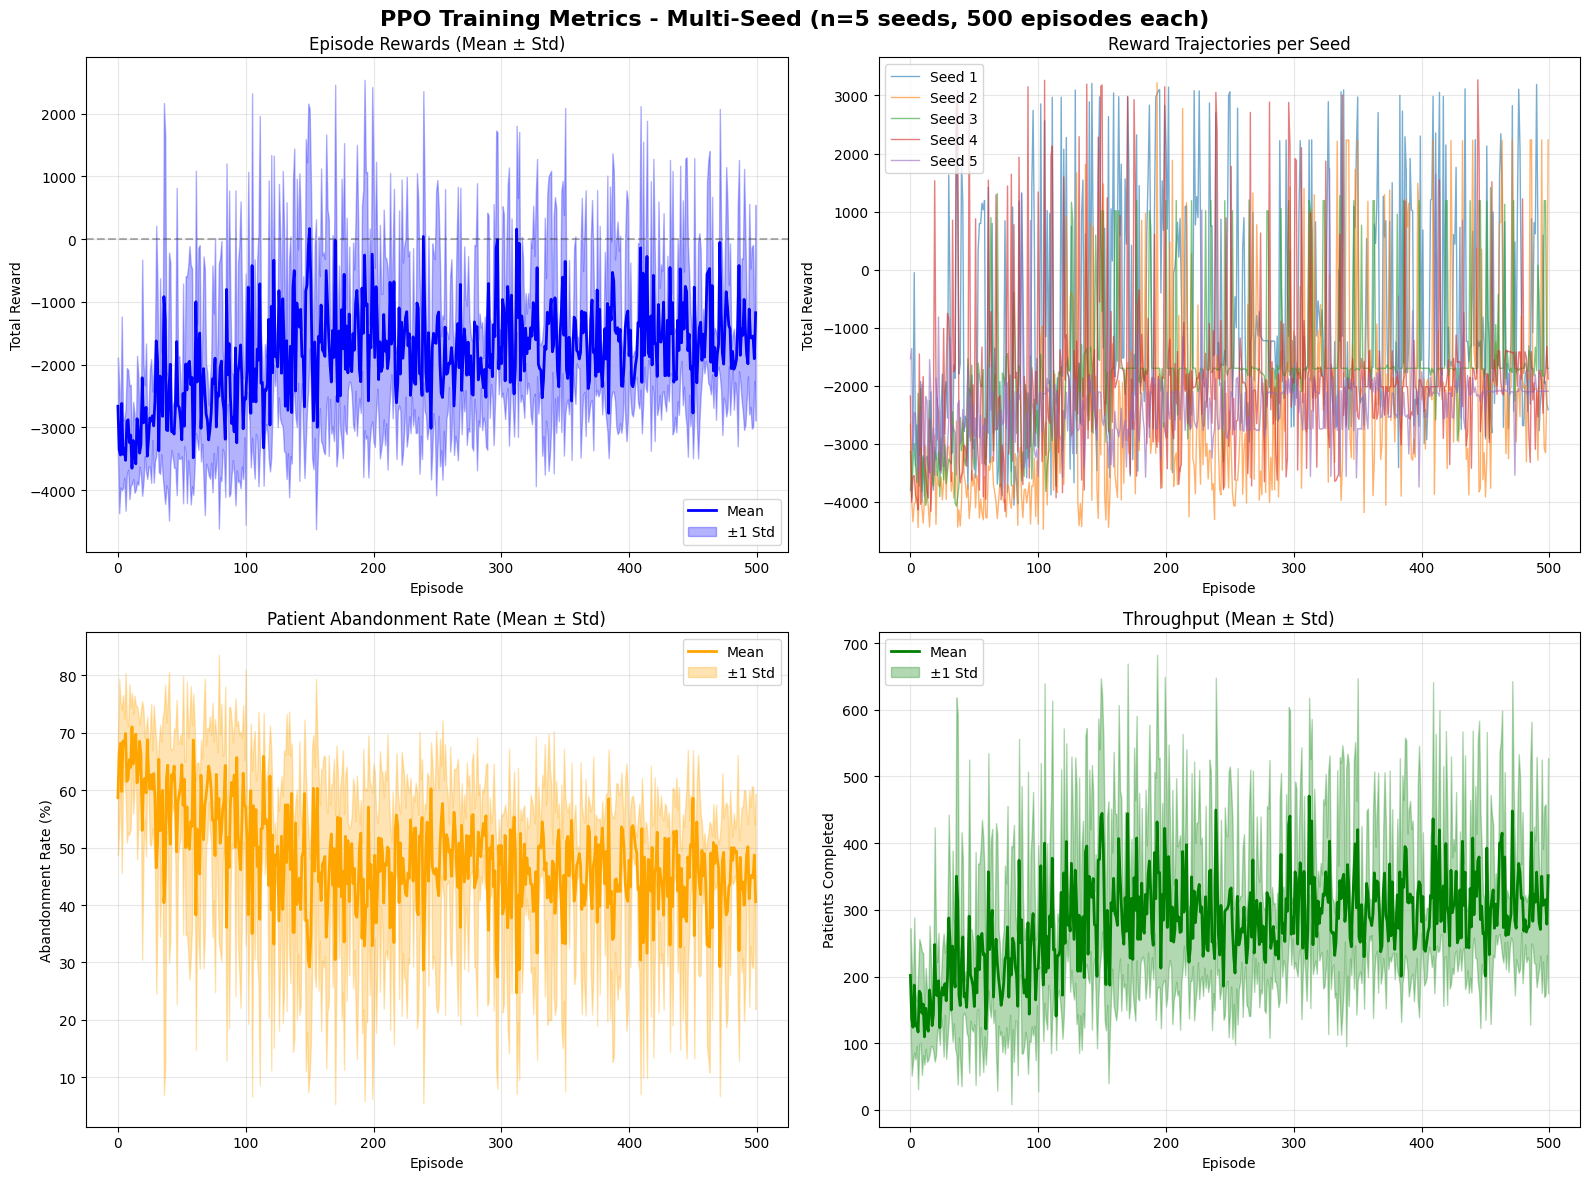


MULTI-SEED SUMMARY STATISTICS (Final 100 Episodes)

Reward:          -1520.80 ± 471.58
Abandonment (%): 44.61 ± 5.29
Throughput:      311.4 ± 44.3

Per-Seed Results:
  Seed 1: Reward=-689.28, Abandon=35.93%, Throughput=360.9
  Seed 2: Reward=-1682.68, Abandon=45.46%, Throughput=321.6
  Seed 3: Reward=-1383.91, Abandon=43.25%, Throughput=343.1
  Seed 4: Reward=-1765.45, Abandon=46.07%, Throughput=297.8
  Seed 5: Reward=-2082.69, Abandon=52.34%, Throughput=233.6

Results saved to 'ppo_multiseed_results.csv'


In [ ]:
# ============================================================================
# MULTI-SEED RESULTS VISUALIZATION
# ============================================================================

# Assuming multi_metrics_ppo is available from previous cell
if 'multi_metrics_ppo' in locals():
    # Convert to arrays
    num_seeds = len(multi_metrics_ppo)
    num_episodes = len(multi_metrics_ppo[0]['rewards'])

    # Stack metrics from all seeds
    all_rewards = np.array([m['rewards'] for m in multi_metrics_ppo])
    all_abandonments = np.array([m['abandonments'] for m in multi_metrics_ppo]) * 100
    all_throughputs = np.array([m['throughputs'] for m in multi_metrics_ppo])

    # Calculate statistics
    mean_rewards = all_rewards.mean(axis=0)
    std_rewards = all_rewards.std(axis=0)

    mean_abandonments = all_abandonments.mean(axis=0)
    std_abandonments = all_abandonments.std(axis=0)

    mean_throughputs = all_throughputs.mean(axis=0)
    std_throughputs = all_throughputs.std(axis=0)

    # Plot
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'PPO Training Metrics - Multi-Seed (n={num_seeds} seeds, {num_episodes} episodes each)',
                 fontsize=16, fontweight='bold')

    episodes_x = np.arange(num_episodes)

    # 1. Rewards with confidence bands
    ax = axes[0, 0]
    ax.plot(episodes_x, mean_rewards, linewidth=2, label='Mean', color='blue')
    ax.fill_between(episodes_x, mean_rewards - std_rewards, mean_rewards + std_rewards,
                     alpha=0.3, label='±1 Std', color='blue')
    ax.axhline(0, color='black', linestyle='--', alpha=0.3)
    ax.set_xlabel('Episode')
    ax.set_ylabel('Total Reward')
    ax.set_title('Episode Rewards (Mean ± Std)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 2. Individual seed trajectories
    ax = axes[0, 1]
    for i in range(num_seeds):
        ax.plot(all_rewards[i], alpha=0.6, linewidth=1, label=f'Seed {i+1}')
    ax.set_xlabel('Episode')
    ax.set_ylabel('Total Reward')
    ax.set_title('Reward Trajectories per Seed')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 3. Abandonment Rate
    ax = axes[1, 0]
    ax.plot(episodes_x, mean_abandonments, linewidth=2, label='Mean', color='orange')
    ax.fill_between(episodes_x, mean_abandonments - std_abandonments,
                     mean_abandonments + std_abandonments,
                     alpha=0.3, label='±1 Std', color='orange')
    ax.set_xlabel('Episode')
    ax.set_ylabel('Abandonment Rate (%)')
    ax.set_title('Patient Abandonment Rate (Mean ± Std)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 4. Throughput
    ax = axes[1, 1]
    ax.plot(episodes_x, mean_throughputs, linewidth=2, label='Mean', color='green')
    ax.fill_between(episodes_x, mean_throughputs - std_throughputs,
                     mean_throughputs + std_throughputs,
                     alpha=0.3, label='±1 Std', color='green')
    ax.set_xlabel('Episode')
    ax.set_ylabel('Patients Completed')
    ax.set_title('Throughput (Mean ± Std)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('ppo_multi_seed_training.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Summary statistics table
    print("\n" + "="*80)
    print("MULTI-SEED SUMMARY STATISTICS (Final 100 Episodes)")
    print("="*80)

    final_rewards = all_rewards[:, -100:].mean(axis=1)
    final_abandonments = all_abandonments[:, -100:].mean(axis=1)
    final_throughputs = all_throughputs[:, -100:].mean(axis=1)

    print(f"\nReward:          {final_rewards.mean():.2f} ± {final_rewards.std():.2f}")
    print(f"Abandonment (%): {final_abandonments.mean():.2f} ± {final_abandonments.std():.2f}")
    print(f"Throughput:      {final_throughputs.mean():.1f} ± {final_throughputs.std():.1f}")

    print("\nPer-Seed Results:")
    for i in range(num_seeds):
        print(f"  Seed {i+1}: Reward={final_rewards[i]:.2f}, "
              f"Abandon={final_abandonments[i]:.2f}%, "
              f"Throughput={final_throughputs[i]:.1f}")

    # Save results to CSV
    results_df = pd.DataFrame({
        'seed': range(1, num_seeds+1),
        'final_reward': final_rewards,
        'final_abandonment': final_abandonments,
        'final_throughput': final_throughputs
    })
    results_df.to_csv('ppo_multiseed_results.csv', index=False)
    print("\nResults saved to 'ppo_multiseed_results.csv'")

else:
    print("Multi-seed metrics not available. Run multi-seed training first.")